In [1]:
import pandas as pd
import numpy as np
import pickle
from datetime import datetime, timedelta

from cosinorage.dataloaders import NHANESDataLoader, plot_orig_enmo, plot_enmo, plot_orig_enmo_freq
from cosinorage.features import WearableFeatures, plot_sleep_predictions, plot_cosinor

%load_ext autoreload
%autoreload 2

In [2]:
reload_nhanes = True

In [3]:
if reload_nhanes:
    nhanes_loader = NHANESDataLoader(nhanes_file_dir='../data/nhanes/', person_id=62164, verbose=True)
    with open("pickle/nhanes_loader.pkl", "wb") as file:
        pickle.dump(nhanes_loader, file)
else:
    with open("pickle/nhanes_loader.pkl", "rb") as file:
        nhanes_loader = pickle.load(file)

Found 1 versions of NHANES data


Reading day-level files: 100%|██████████| 1/1 [00:00<00:00, 26.18it/s]


Read 9 day-level records for person 62164


Reading minute-level files:   0%|          | 0/1 [00:00<?, ?it/s]
Processing chunks for version G: 0it [00:00, ?it/s]
Processing chunks for version G: 2it [00:00, 13.00it/s]
Processing chunks for version G: 4it [00:00, 13.21it/s]
Processing chunks for version G: 6it [00:00, 13.40it/s]
Processing chunks for version G: 8it [00:00, 13.33it/s]
Processing chunks for version G: 10it [00:00, 13.26it/s]
Processing chunks for version G: 12it [00:00, 13.18it/s]
Processing chunks for version G: 14it [00:01, 13.09it/s]
Processing chunks for version G: 16it [00:01, 13.09it/s]
Processing chunks for version G: 18it [00:01, 13.19it/s]
Processing chunks for version G: 20it [00:01, 13.09it/s]
Processing chunks for version G: 22it [00:01, 12.98it/s]
Processing chunks for version G: 24it [00:01, 12.99it/s]
Processing chunks for version G: 26it [00:01, 13.11it/s]
Processing chunks for version G: 28it [00:02, 13.08it/s]
Processing chunks for version G: 30it [00:02, 12.96it/s]
Processing chunks for version G

Read 11529 minute-level records for person 62164


Reading header files: 100%|██████████| 1/1 [00:00<00:00, 123.85it/s]


Merged day- and minute-level data for person 62164
Renamed columns and set timestamp index for person 62164
Calculated ENMO for person 62164
Loaded 10080 minute-level ENMO records from ../data/nhanes/
Filtered out 0 minute-level ENMO records due to incomplete daily coverage
Filtered out 0 minute-level ENMO records due to filtering for longest consecutive sequence of days
Resampled 10080 to 10080 timestamps
__load_data executed in 61.78 seconds


/Users/jacobleooskar/Documents/Education/ETHZ/Curriculum/Semester03/03SemProj/CosinorAge/cosinorage/dataloaders/utils/nhanes.py:167: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  _data = _data.resample('1min').interpolate(method='linear').bfill()


In [4]:
nhanes_loader.get_ml_data().head()

,X,Y,Z,wear,sleep,paxpredm,ENMO
TIMESTAMP,,,,,,,
1900-01-02 00:00:00,5.397605e-79,5.397605e-79,5.397605e-79,1,1,2,0.0
1900-01-02 00:01:00,5.397605e-79,5.397605e-79,5.397605e-79,1,1,2,0.0
1900-01-02 00:02:00,5.397605e-79,5.397605e-79,5.397605e-79,1,1,2,0.0
1900-01-02 00:03:00,5.397605e-79,5.397605e-79,5.397605e-79,1,1,2,0.0
1900-01-02 00:04:00,5.397605e-79,5.397605e-79,5.397605e-79,1,1,2,0.0


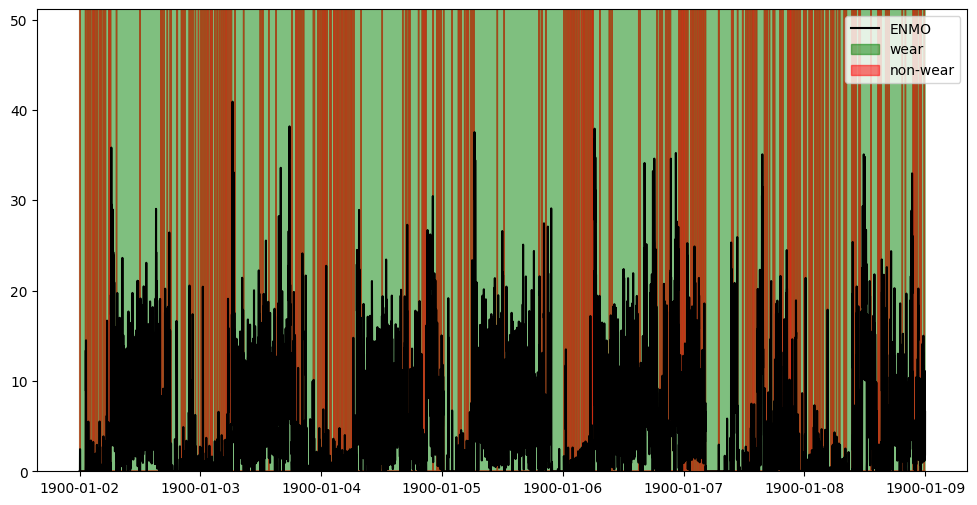

In [5]:
plot_enmo(nhanes_loader)

In [6]:
features = WearableFeatures(nhanes_loader)
features.run()
df, dict = features.get_all()


/Users/jacobleooskar/Documents/Education/ETHZ/Curriculum/Semester03/03SemProj/CosinorAge/cosinorage/features/utils/cosinor_analysis.py:60: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  fitted_vals_df = pd.concat([fitted_vals_df, model.fittedvalues], ignore_index=False)


In [7]:
df

,MESOR,amplitude,acrophase,acrophase_time,IV,IS,RA,M10,M10_start,L5,L5_start,SB,LIPA,MVPA,TST,WASO,PTA,SRI
1900-01-02,4.194609,4.593569,3.006855,11.485340,0.553234,0.310854,0.955252,8.365472,6,0.191452,0,10.533333,0.000000,13.466667,905,529.0,0.628472,NaN
1900-01-03,4.803938,4.422045,3.404201,13.003091,0.519078,0.250183,0.933992,8.939045,17,0.305092,2,9.033333,0.000000,14.966667,974,458.0,0.676389,58.472222
1900-01-04,5.012393,2.489812,3.800985,14.518693,0.649806,0.319540,0.924919,8.439007,21,0.329160,5,6.433333,0.016667,17.550000,1182,248.0,0.820833,46.388889
1900-01-05,5.484251,4.096234,3.516980,13.433876,0.575909,0.287222,0.971098,8.646607,6,0.126786,22,7.783333,0.016667,16.200000,1010,430.0,0.701389,58.888889
1900-01-06,6.134147,3.395487,4.035695,15.415219,0.608270,0.257791,0.930901,10.211573,22,0.365432,2,6.000000,0.016667,17.983333,1235,191.0,0.857639,60.138889
1900-01-07,3.467894,1.231169,5.305691,20.266246,0.472333,0.367982,0.985093,6.656131,15,0.049983,5,11.550000,0.066667,12.383333,827,613.0,0.574306,-8.055556
1900-01-08,4.382392,3.788104,4.198167,16.035818,0.429239,0.260761,0.946060,8.343865,11,0.231270,8,9.366667,0.050000,14.583333,967,470.0,0.671528,24.444444


In [8]:
dict

{'MESOR': 4.782803509320714,
 'amplitude': 2.966677925003311,
 'acrophase': 3.6730470085059936,
 'acrophase_time': 14.03000610270307}

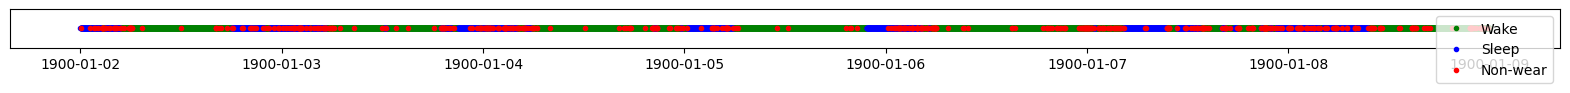

In [9]:
plot_sleep_predictions(features)

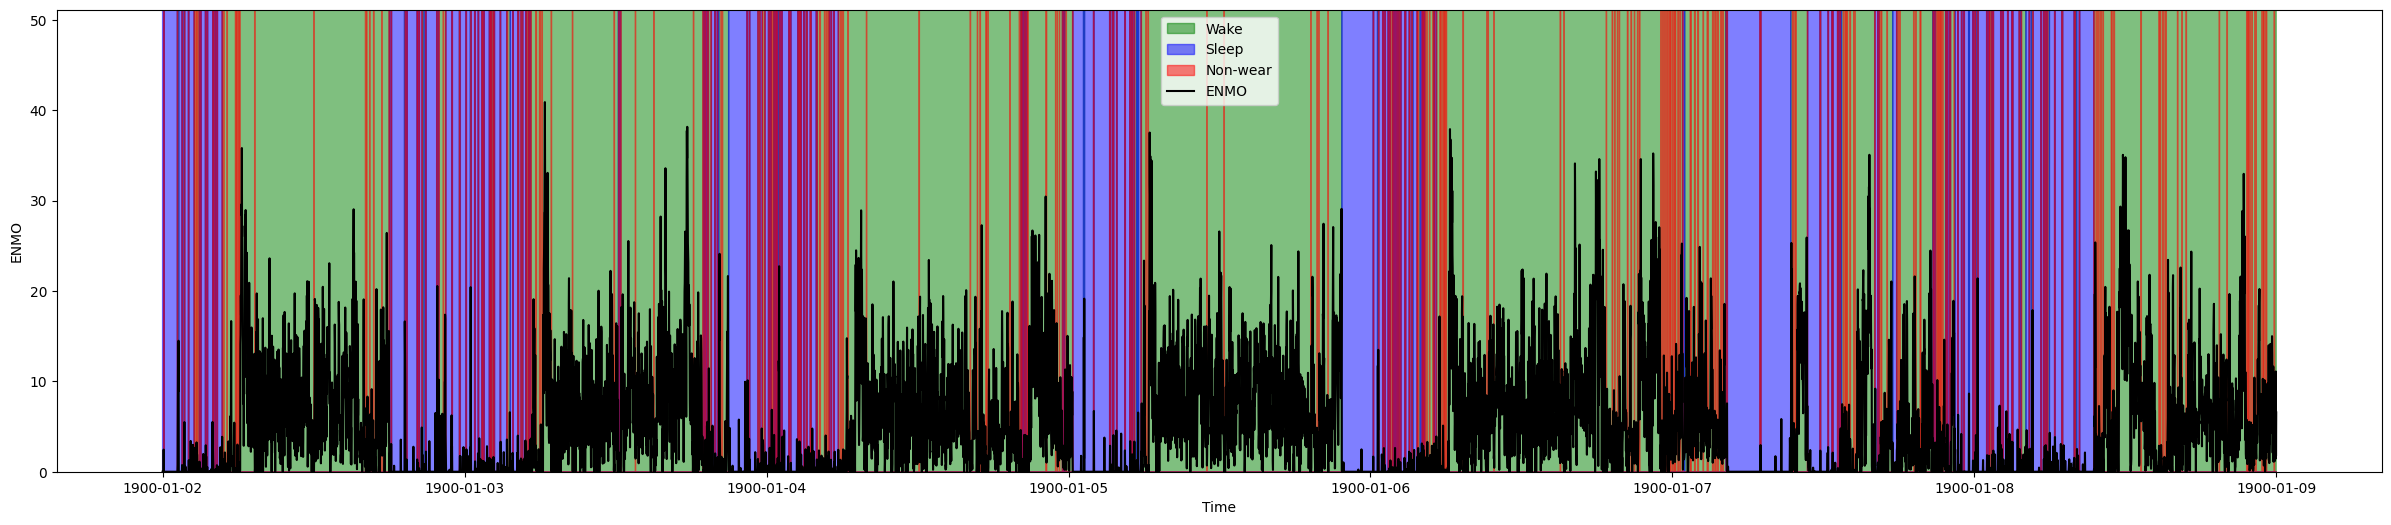

In [10]:
plot_sleep_predictions(features, simple=False)

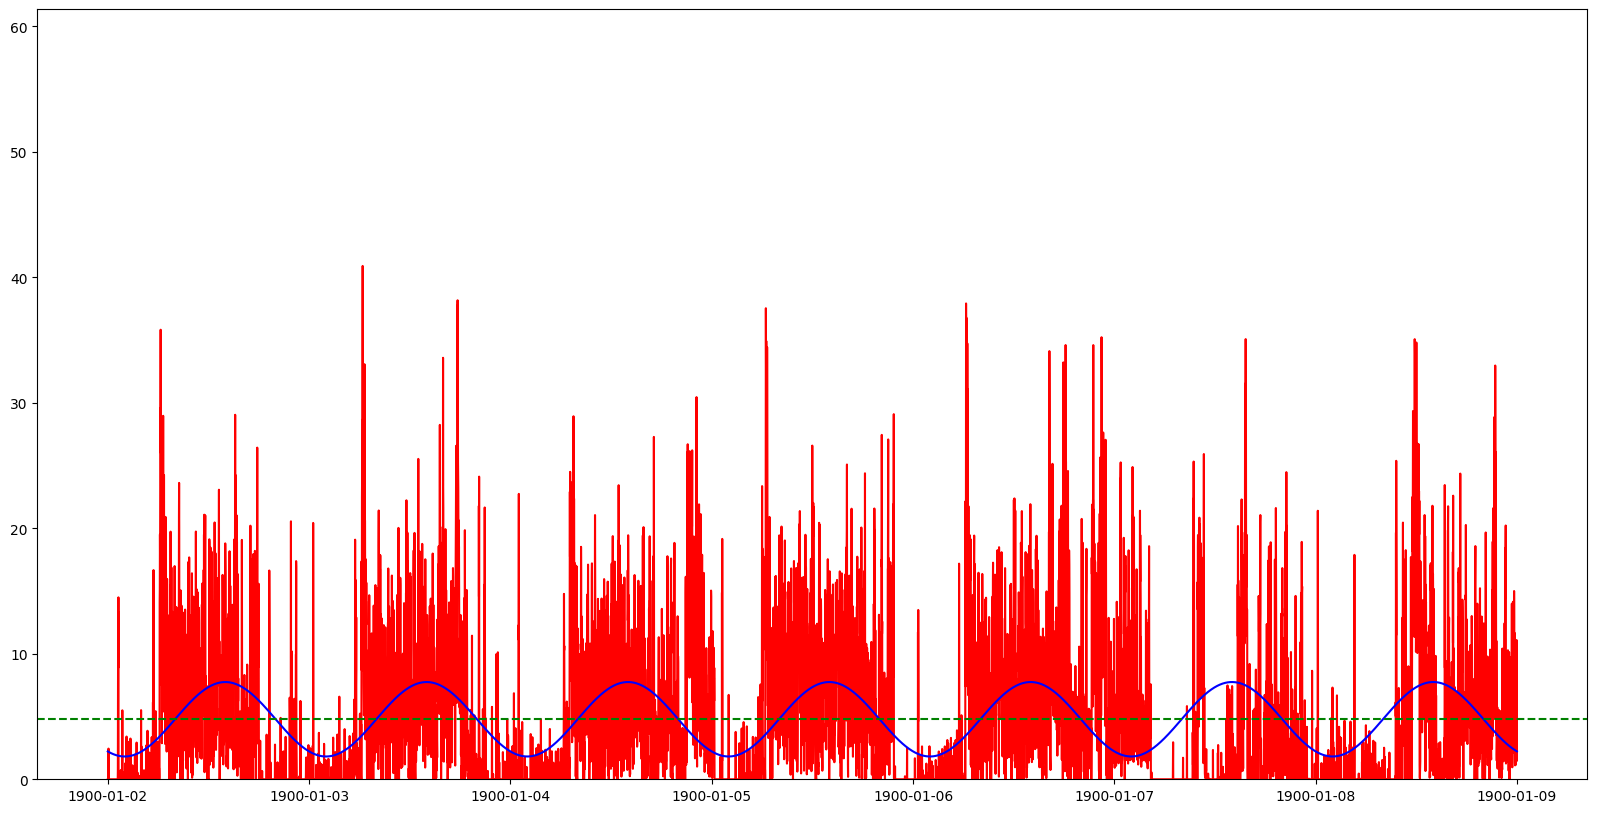

In [11]:
plot_cosinor(features)


In [12]:
by_day, multiday = features.get_cosinor_features()

In [13]:
multiday

{'MESOR': 4.782803509320714,
 'amplitude': 2.966677925003311,
 'acrophase': 3.6730470085059936,
 'acrophase_time': 14.03000610270307}

In [14]:
by_day

,MESOR,amplitude,acrophase,acrophase_time
1900-01-02,4.194609,4.593569,3.006855,11.485340
1900-01-03,4.803938,4.422045,3.404201,13.003091
1900-01-04,5.012393,2.489812,3.800985,14.518693
1900-01-05,5.484251,4.096234,3.516980,13.433876
1900-01-06,6.134147,3.395487,4.035695,15.415219
1900-01-07,3.467894,1.231169,5.305691,20.266246
1900-01-08,4.382392,3.788104,4.198167,16.035818


In [15]:
nhanes_loader.get_meta_data()

{'datasource': 'nhanes',
 'raw_data_frequency': 0.016666666666666666,
 'raw_data_type': 'accelerometer',
 'raw_data_unit': 'm/s^2',
 'n_days': 7}